In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np

batch_size=64
epochs=100
latent_dim=256
num_samples=10000
data_path='/content/drive/My Drive/fra.txt'

In [5]:
input_texts=[]
target_texts=[]
input_characters=set()
target_characters=set()
with open(data_path,'r',encoding='utf-8') as f:
  lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines)-1)]:
  input_text,  target_text, _ = line.split('\t')
  target_text='\t'+target_text+'\n'
  input_texts.append(input_text)
  target_texts.append(target_text)
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)


In [6]:
input_characters=sorted(list(input_characters))
target_characters=sorted(list(target_characters))
num_encoder_tokens=len(input_characters)
num_decoder_tokens=len(target_characters)
max_encoder_seq_length=max([len(txt) for txt in input_texts])
max_decoder_seq_length=max([len(txt) for txt in target_texts])

In [7]:
print('Number of samples:',len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 91
Max sequence length for inputs: 14
Max sequence length for outputs: 59


In [8]:
input_token_index = dict(
    [(char,i) for i, char in enumerate(input_characters)]
)
target_token_index = dict(
    [(char,i) for i, char in enumerate(target_characters)]
)

In [9]:
encoder_input_data=np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32'
)
decoder_input_data=np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32'
)
decoder_target_data=np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32'
)


In [10]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] =1.
  encoder_input_data[i, t+1:, input_token_index[' ']] =1.
  for t, char in enumerate(target_text):
    decoder_input_data[i, t, target_token_index[char]] =1.
    if t > 0:
      decoder_target_data[i, t-1, target_token_index[char]] =1.
  decoder_input_data[i, t+1:, target_token_index[' ']] =1.
  decoder_target_data[i, t:, target_token_index[' ']] =1.

In [11]:
encoder_input_data[0].shape

(14, 70)

In [12]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

In [13]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [14]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size, epochs= epochs, validation_split=0.2)


Epoch 1/100
125/125 [==============================] - 24s 171ms/step - loss: 1.2090 - accuracy: 0.7336 - val_loss: 1.0633 - val_accuracy: 0.7141
Epoch 2/100
125/125 [==============================] - 21s 166ms/step - loss: 0.9328 - accuracy: 0.7502 - val_loss: 0.9671 - val_accuracy: 0.7235
Epoch 3/100
125/125 [==============================] - 20s 163ms/step - loss: 0.8396 - accuracy: 0.7676 - val_loss: 0.8828 - val_accuracy: 0.7536
Epoch 4/100
125/125 [==============================] - 21s 165ms/step - loss: 0.7485 - accuracy: 0.7910 - val_loss: 0.7875 - val_accuracy: 0.7728
Epoch 5/100
125/125 [==============================] - 21s 165ms/step - loss: 0.6721 - accuracy: 0.8069 - val_loss: 0.7246 - val_accuracy: 0.7942
Epoch 6/100
125/125 [==============================] - 20s 163ms/step - loss: 0.6283 - accuracy: 0.8176 - val_loss: 0.6832 - val_accuracy: 0.8037
Epoch 7/100
125/125 [==============================] - 20s 163ms/step - loss: 0.5995 - accuracy: 0.8248 - val_loss: 0.6549 -

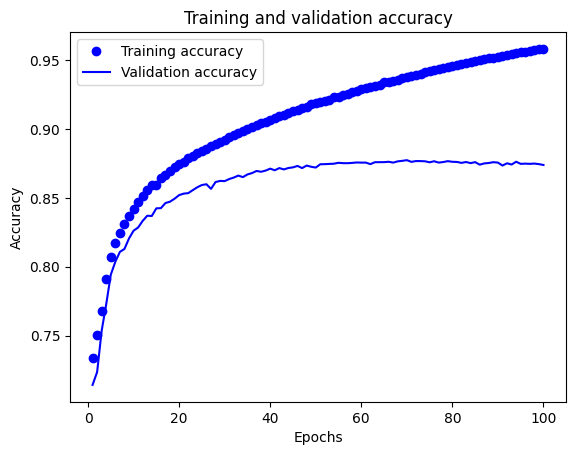

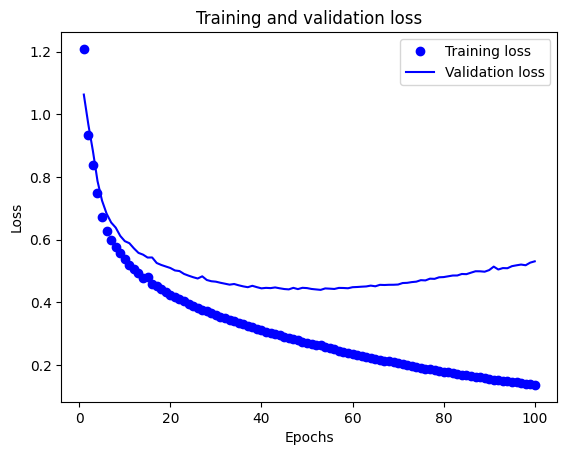

In [17]:
import matplotlib.pyplot as plt

# Extracting the training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [55]:
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_state_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_state_inputs,
    [decoder_outputs] + decoder_states
)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items()
)
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items()
)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

for seq_index in range(100):
    input_seq = encoder_input_data[seq_index: seq_index+1]
    decoded_sentence = decode_sequence(input_seq)
    print('Input sentence: ', input_texts[seq_index])
    print('Decoded sentence: ', decoded_sentence)

1/1 [==============================] - 0s 27ms/step
Input sentence:  Go.
Decoded sentence:  Achone-tui.

1/1 [==============================] - 0s 27ms/step
Input sentence:  Go.
Decoded sentence:  Achone-tui.

1/1 [==============================] - 0s 26ms/step
Input sentence:  Go.
Decoded sentence:  Achone-tui.

1/1 [==============================] - 0s 25ms/step
Input sentence:  Go.
Decoded sentence:  Achone-tui.

1/1 [==============================] - 0s 26ms/step
Input sentence:  Hi.
Decoded sentence:  Salut !

1/1 [==============================] - 0s 26ms/step
Input sentence:  Hi.
Decoded sentence:  Salut !

1/1 [==============================] - 0s 26ms/step
Input sentence:  Run!
Decoded sentence:  Fuyez !

1/1 [==============================] - 0s 25ms/step
Input sentence:  Run!
Decoded sentence:  Fuyez !

1/1 [==============================] - 0s 26ms/step
Input sentence:  Run!
Decoded sentence:  Fuyez !

1/1 [==============================] - 0s 26ms/step
Input sentence:  Run

In [46]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

# Define the constants and variables used in your code
# Ensure you have the trained model (model) and the necessary dictionaries (input_token_index, target_token_index, etc.)

# Define the function to decode a sequence
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

# Function to translate an input sentence
def translate_sequence(input_sentence):
    # Process the input sentence into the appropriate format
    input_seq = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    for t, char in enumerate(input_sentence):
        input_seq[0, t, input_token_index[char]] = 1.
    input_seq[0, t + 1:, input_token_index[' ']] = 1.

    # Decode the input sequence
    translated_sentence = decode_sequence(input_seq)

    return translated_sentence

In [59]:
english_sentence = "Hello,I am Tom"
french_translation = translate(english_sentence)
print(french_translation)

Bonjour, je suis Tom


In [63]:
english_sentence = "Tom is good"
french_translation = translate(english_sentence)
print(french_translation)

Tom est bon


In [62]:
english_sentence = "where do you live"
french_translation = translate(english_sentence)
print(french_translation)

où  habites-tu


In [61]:
english_sentence = "i love birds"
french_translation = translate(english_sentence)
print(french_translation)

J'adore les oiseaux


In [60]:
english_sentence = "Good night"
french_translation = translate(english_sentence)
print(french_translation)

Bonne nuit


In [64]:
english_sentence = "Good night people"
french_translation = translate(english_sentence)
print(french_translation)

Bonne nuit les gens
